<img src="https://cdn.siberian.dev/siberian.png" alt="Siberian Logo">

### Image Classification Using ResNet50

This Code Template is for simple image classification using Resnet50. This architecture introduced the concept of Residual Block to solve the problem of the vanishing/exploding gradient.

# Required Packages

In [28]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import os
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from glob import glob

### Initialization
Path of the main folder containing train and test folders

In [23]:
BASE_DIR = ''
print(os.listdir(BASE_DIR))

['test_set', 'training_set']


Path of the train and test folders containing image files

In [24]:
train_dir = os.path.join(BASE_DIR, 'train') #train
test_dir = os.path.join(BASE_DIR, 'test') #test

List of target categories which are required for model training and predictions.

In [25]:
target = []

In [26]:
print(len(target))

2


### Directory Structure
The OS module in Python provides functions for interacting with the operating system. This module provides a portable way of using operating system-dependent functionality.
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>Master Directory</b>
 |__<b>train</b>
    |______ <b>Class 1</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 2</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 3</b>: [1.jpg, 2.jpg, 3.jpg ....]
    :
    :
 |__<b>test</b>
    |______ <b>Class 1</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 2</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 3</b>: [1.jpg, 2.jpg, 3.jpg ....]
    :
    :
</pre>

In [31]:
# useful for getting number of files
train_image_files = glob(train_dir + '/*/*.jp*g')
test_image_files = glob(test_dir + '/*/*.jp*g')

### Prepare  Data 



In [ ]:
image_size = IMAGE_RESIZE

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        'train_image_files',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        'train_image_files',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

### Global Constants

In [2]:
# Fixed for our Cats & Dogs classes
NUM_CLASSES = 2

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

### Define Our Transfer Learning Network Model Consisting of 2 Layers

Here, we are preparing specification or blueprint of the TensorFlow DAG (directed acyclcic graph) for just the MODEL part.

In [5]:
#Still not talking about our train/test data or any pre-processing.

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = resnet_weights_path))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


### Compile Our Transfer Learning Model

In [7]:
from tensorflow.python.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [9]:
# Max number of steps that these generator will have opportunity to process their source content
# len(train_generator) should be 'no. of available train images / BATCH_SIZE_TRAINING'
# len(valid_generator) should be 'no. of available train images / BATCH_SIZE_VALIDATION'
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(100, 200, 100, 50)

### Train Our Model With Cats & Dogs Train (splitted) Data Set

In [10]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')


In [12]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights("../working/best.hdf5")

Epoch 1/10
10/10 [==============================] - 20s 2s/step - loss: 0.3226 - acc: 0.8450 - val_loss: 0.0590 - val_acc: 0.9750
Epoch 2/10
10/10 [==============================] - 11s 1s/step - loss: 0.0701 - acc: 0.9760 - val_loss: 0.0544 - val_acc: 0.9810
Epoch 3/10
10/10 [==============================] - 11s 1s/step - loss: 0.0694 - acc: 0.9690 - val_loss: 0.0503 - val_acc: 0.9810
Epoch 4/10
10/10 [==============================] - 10s 1s/step - loss: 0.0831 - acc: 0.9670 - val_loss: 0.0596 - val_acc: 0.9790
Epoch 5/10
10/10 [==============================] - 10s 964ms/step - loss: 0.0749 - acc: 0.9710 - val_loss: 0.0601 - val_acc: 0.9850
Epoch 6/10
10/10 [==============================] - 10s 965ms/step - loss: 0.0746 - acc: 0.9740 - val_loss: 0.0465 - val_acc: 0.9820
Epoch 7/10
10/10 [==============================] - 9s 866ms/step - loss: 0.0595 - acc: 0.9730 - val_loss: 0.0653 - val_acc: 0.9790
Epoch 8/10
10/10 [==============================] - 9s 902ms/step - loss: 0.0667 -

### Training Metrics

One of the default callbacks that is registered when training all deep learning models is the History callback. It records training metrics (training accuracy, training loss, validation loss & validation accuracy) for each epoch. Note that training accuracy & loss during epoch steps are somewhat incomplete information and they are not recorded in history.

Observe that training uses early stopping, hence metrics is available for epochs run, not for NUM_EPOCHS.

In [13]:
print(fit_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


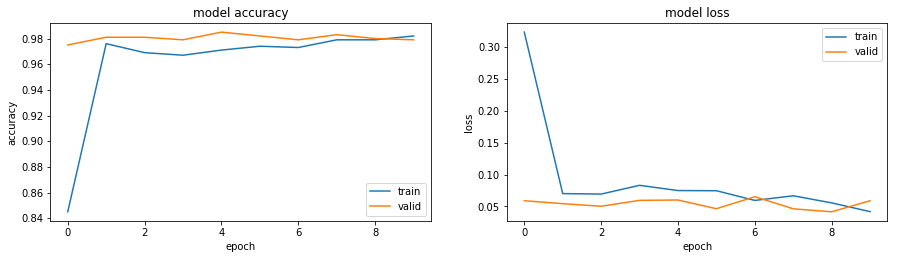

In [14]:
 plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [15]:
# NOTE that flow_from_directory treats each sub-folder as a class which works fine for training data
# Actually class_mode=None is a kind of workaround for test data which too must be kept in a subfolder

# batch_size can be 1 or any factor of test dataset size to ensure that test dataset is samples just once, i.e., no data is left out
test_generator = data_generator.flow_from_directory(
    directory = '../input/test-files-prepd/test4keras/test4keras',
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

# Try batch size of 1+ in test_generator & check batch_index & filenames in resulting batches
'''
for i in test_generator:
    #print(test_generator.batch_index, test_generator.batch_size)
    idx = (test_generator.batch_index - 1) * test_generator.batch_size
    print(test_generator.filenames[idx : idx + test_generator.batch_size])
'''

Found 12500 images belonging to 1 classes.


'\nfor i in test_generator:\n    #print(test_generator.batch_index, test_generator.batch_size)\n    idx = (test_generator.batch_index - 1) * test_generator.batch_size\n    print(test_generator.filenames[idx : idx + test_generator.batch_size])\n'

### Observe Prediction Time With Different Batch Size

With GPU, 97s for full prediction with batch_size=100 -vs- 264s with 1. But note that to avoid ImageDataGenerator iterator repeatability, we need to use 1 as batch_size.

In [16]:
# Reset before each call to predict
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

12500/12500 [==============================] - 138s 11ms/step


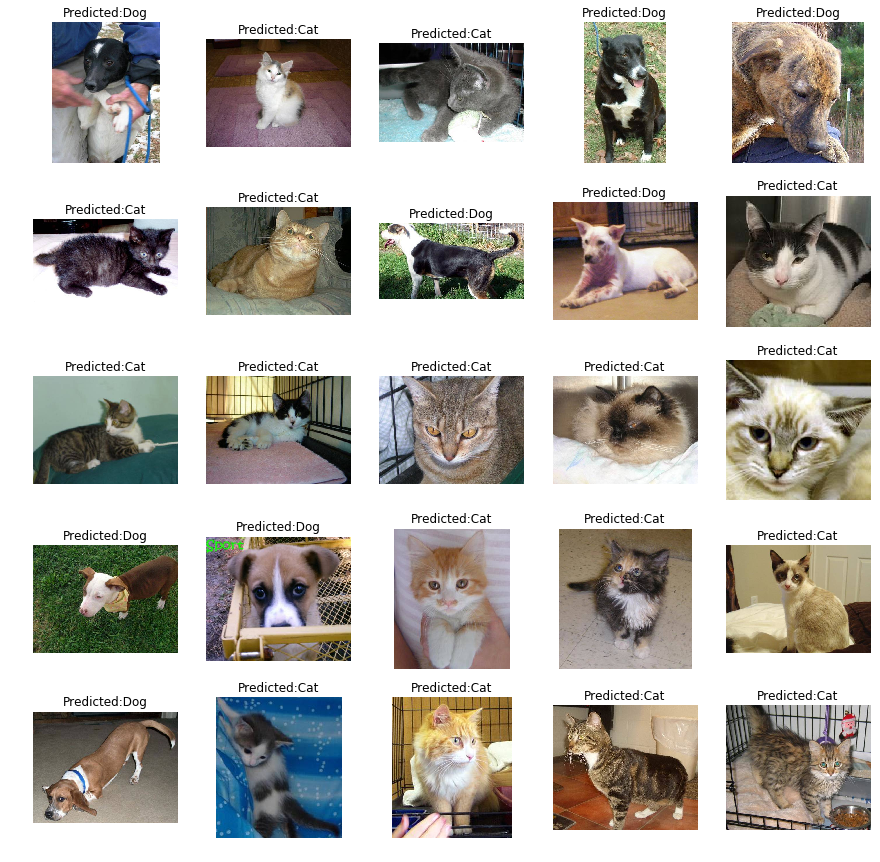

In [17]:
TEST_DIR = '../input/test-files-prepd/test4keras/test4keras/'
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "Dog" if predicted_class_indices[i] else "Cat"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()

#### Creator: Vipin Kumar , Github: [Profile](https://github.com/devVipin01)